<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/14_rl/01_Deep_Q_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的
Deep Q-networkの仕組みを理解し，ゲームタスクを用いて強化学習をおこなう．\
学習後のエージェントの可視化を行い，学習がうまくできているか確認を行う．

# Deep Q-Network(DQN)
Deep Q-Network(DQN)は，GoogleのDeep mindチームが2016年に発表した手法で，Q学習におけるQテーブルを用いた行動価値の導出をDCNNを用いた近似関数で代用するのが主な手法の内容である．それまでのQ学習ではすべての状態と行動に組み合わせについての行動価値をQテーブルに記録していたために状態数と行動数の組み合わせが膨大な環境に対して膨大なメモリが必要となる問題を抱えていました．これに対してDQNはQテーブルそのものをDCNNで代用することにより膨大な行動数と状態数の組み合わせが存在する環境に対しても学習を行うことが可能となり，atari2600のゲーム環境において人間を超えるスコアを出すことに成功している．また，DQNにはその他にも強化学習における学習の安定性獲得のためにExperience replay，Target Q-Network，reward_clippingなどの工夫がなされている．行動価値関数(Q値)を用いて行動を決定し，最適行動価値関数になるよう更新を行っていく手法は，価値ベースの手法と呼ばれている．派生手法には，DDQN，Ape-X，R2D2などの手法がある．\
<img src="http://drive.google.com/uc?export=view&id=1l0150_Sp4xloftXrUlXQOTsNIAWN3a8F" width = 50%>


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


### モジュールの追加インストール
下記のプログラムを実行して，実験結果の表示に必要な追加ライブラリやモジュールをインストールする．

In [1]:
!apt-get -qq -y install libcusparse9.1 libnvrtc9.1 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.9.1 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回はPyTorchに加えて，Cart Poleを実行するためのシミュレータであるopenAI Gym（gym）をインポートする．

In [3]:
import numpy as np
import gym
import gym.spaces

import time
import math
import random
import cv2
import matplotlib
import matplotlib.pyplot as plt
import collections
from itertools import count
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# 使用するデバイス（GPU or CPU）の決定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device:", device)

Use device: cuda


## OpenAI GymによるPongの環境の定義
 [OpenAI Gym](https://github.com/openai/gym) は，様々な種類の環境を提供しているモジュールです．
 
 今回はgymで利用できるatariゲームであるPongを実行します．
 まず，gym.make関数で実行したい環境を指定します．
 その後，reset関数を実行することで，環境を初期化します．
 
Pong環境は，パドルを操作してボールが自分の陣地に入らないように打ち返すゲームです．Pong環境において現在の状態を確認するためにゲームの画面情報が与えられており，`observation_space`という変数で確認することができます．
また，`action_space`という変数で，エージェントが取ることのできる行動の数を確認することができます．
Pongの場合は，パドルを上下どちらかに移動させるという行動を取るため，行動の数は2となっています．
Pongのゲーム概要は，相手の陣地にボールを入れることで得点を獲得し，ボールを自分の陣地に入れられることで得点を取られます．どちらかのプレイヤーが21点取った時点で終了となります．




In [4]:
# 環境の指定
env = gym.make('CartPole-v0')

# 環境の初期化
obs = env.reset()
#env.render()
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('initial observation:', obs)

# 行動の決定と決定した行動の入力
action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
initial observation: [-0.01163751  0.0287326  -0.04824682 -0.02701885]
next observation: [-0.01106285 -0.16566544 -0.0487872   0.25005984]
reward: 1.0
done: False
info: {}


## ネットワーク構造
ネットワークモデルを定義します． ここでは，環境からのゲーム画面情報を入力し，行動に対するQ値を出力するようなネットワークを定義するために，畳み込み層3層と全結合層2層から構成されるネットワークとします．

入力データのサイズをinput_shape，出力する行動の数をn_actionsとし，ネットワークの作成時に変更できるようにしておきます．

In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

## Deep Q-Networkにおける学習工夫の定義

Deep Q-Networkでは学習の促進と安定化の為に，いくつ工夫を施して学習を行っています．代表的な工夫としてExperience Replay, Target Q-Network, Reward Clippingと呼ばれる3つの工夫があります．


### Experience Replay
DQNは環境の状態を直接観測するのではなく一度Replay Bufferと呼ばれるBufferに経験を格納しておき，学習する際に格納したランダムな経験を取ってくることによって学習を行っています．これをExperience Replayと呼びデータの再利用をおこなうことで，データ効率を高め効率的な学習をおこないます．ここでは，replay memoryの定義を行います．

memoryへは，現在の状態，その時に選択された行動，行動によって遷移した状態（次状態），その時の報酬の4種類の情報を1つの経験として蓄積します． まず，Experienceという変数を定義します． ここでは，state, action, reward, done, next_stateが1セットとなるようなデータ構造（辞書オブジェクト）を定義します．

その後Experience Bufferクラスを定義します． Experience Bufferクラスでは，memoryへ格納する経験の数（capacity），経験を蓄積するbuffer（buffer）を定義します． append関数では，メモリへ経験を格納します． また，sample関数では，指定したバッチサイズ (batch_size) 分の経験をランダムに選択し，返す関数を定義します．

In [6]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

### Target Q-Network
強化学習で誤差を計算する際，目標値として使用される行動価値関数と現在の行動価値関数をそれぞれ別のネットワークの出力を用いて誤差を計算します．目標値の行動価値関数を出力するネットワークは一定周期経過するまで固定したネットワークとし，一定周期で現在のネットワークと同期しながら学習を行う工夫がTarget Q-Networkです．この工夫により，学習の安定化を図ります．

target_netを現在のnetと同期するsync_networkを定義します．

In [7]:
def sync_network():
    tgt_net.load_state_dict(net.state_dict())

### reward clipping
学習における報酬値を −1 から 1 の範囲に指定します．これにより,学習における外れ値に対する過剰反応を防ぐことができます.

reward clippingは環境に直接ラップするためwrapperクラスを定義します．reward関数では，環境から受け取った報酬を-1から1の範囲にクリップします．

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

## その他の学習に必要な処理
gymのatari環境で学習の安定化と効率的な学習を行うための処理をいくつか行います．

In [9]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """For environments where the user need to press FIRE for the game to start."""
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

### 学習に必要な処理の適用
環境に対して必要となるそれぞれの処理を作成した環境に対して適用します．

In [10]:
env = gym.make("PongNoFrameskip-v4")
env = ClipRewardEnv(env)
env = MaxAndSkipEnv(env)
env = FireResetEnv(env)
env = ProcessFrame84(env)
env = ImageToPyTorch(env)
env = BufferWrapper(env, 4)
env = ScaledFloatFrame(env)

## エージェントの定義
エージェントが環境に対して行動価値に沿った行動を行い，環境から経験を取得し，Experience Buffer記録にするようにします．

エージェントの環境に対する動きのクラスを定義します．play_step関数は，環境にたいして行動を決定する関数です．epsilon-greedy法を用いて一定の割合でランダムに行動選択を行います．それ以外の場合は，使用しているネットワークへ環境情報を入力し，行動を決定します．

In [11]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net=None, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

## TD誤差の計算
強化学習は，TD誤差と呼ばれる次状態の推定の価値と実際に起こした行動から得られる価値の差を用いて学習を行います．次状態の推定の価値を教師あり学習の教師と同じ役割として計算します．DQNはQ学習をもとにしているため，現在の行動価値関数を最適行動価値関数になるように更新を行っていきます．

TD誤差の計算を行う関数を定義します．calc_loss関数では，replay_bufferからランダムに取得したbatch分の経験をもとに下記のLoss計算を行います．

\
$$
L_{\theta}=\frac{1}{2}(r+\gamma \max_{a'}Q_{\theta_{i}}(s',a')-Q_{\theta_{i}}(s,a))^{2}
$$


In [12]:
def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

## 学習
DQNを用いて学習を行います．学習環境はatari環境のPongゲーム環境を用います．各パラメータを定義します．Experience Replayで利用するReplay Bufferのサイズは1万とし，Replay Bufferが埋まるまでエージェントがランダムで動き，経験を貯めてから学習を行います．

学習回数を100万frame(num_frame)分とし，環境の終了条件はどちらかが21点とったら終了としています．また，最適化手法にはRMSprop利用します．

学習を開始します． まず，環境を初期化し，経験をReplayBufferへ蓄積します． 十分に蓄積された後，パラメータの更新を行います． また，SNC_TARGET_FRAMESで指定した回数ごとに，target_netのパラメータをnetのパラメータと同じになるようにコピーを行います．

In [13]:
MEAN_REWARD_BOUND = 19.5

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02

num_frame = 1000000

device = 'cuda:0'

Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts = time.time()
ts_frame = 0
best_mean_reward = None

while frame_idx < num_frame:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        print("%d: done %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
            frame_idx, len(total_rewards), mean_reward, epsilon,
            speed
        ))
        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), "Pong" + "-best.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if len(total_rewards) == 1000000:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        sync_network()

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

959: done 1 games, mean reward -20.000, eps 0.99, speed 656.22 f/s
1782: done 2 games, mean reward -20.500, eps 0.98, speed 659.22 f/s
2849: done 3 games, mean reward -20.333, eps 0.97, speed 678.75 f/s
4195: done 4 games, mean reward -19.500, eps 0.96, speed 673.94 f/s
Best mean reward updated -20.000 -> -19.500, model saved
5114: done 5 games, mean reward -19.600, eps 0.95, speed 638.68 f/s
5954: done 6 games, mean reward -19.667, eps 0.94, speed 660.51 f/s
6776: done 7 games, mean reward -19.857, eps 0.93, speed 662.44 f/s
7658: done 8 games, mean reward -20.000, eps 0.92, speed 652.97 f/s
8498: done 9 games, mean reward -20.000, eps 0.92, speed 656.98 f/s
9320: done 10 games, mean reward -20.100, eps 0.91, speed 644.16 f/s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  if sys.path[0] == '':


10161: done 11 games, mean reward -20.091, eps 0.90, speed 298.85 f/s
11031: done 12 games, mean reward -20.167, eps 0.89, speed 98.73 f/s
11899: done 13 games, mean reward -20.154, eps 0.88, speed 94.60 f/s
12917: done 14 games, mean reward -20.143, eps 0.87, speed 99.48 f/s
13739: done 15 games, mean reward -20.200, eps 0.86, speed 96.67 f/s


KeyboardInterrupt: ignored

## 評価
学習したネットワーク（エージェント）を確認してみます．

ここでは，framesに描画したフレームを順次格納します．

In [37]:
# 結果を描画するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)


frames = []
for i in range(3):
    state = env.reset()
    done = False
    t = 0
    
    while not done and t < 200:
        frames.append(env.render(mode='rgb_array'))
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a).to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        new_state, reward, is_done, _ = env.step(action)
        state = new_state
        done = is_done
        t += 1

## 描画

maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．

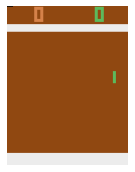

In [33]:
# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 課題